In [1]:
# import relevant modules
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import os
import imblearn
from time import time
from scipy.stats import chi2_contingency
from sklearn import preprocessing #Used only for Data Preprocessing
from numpy import argmax

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Settings
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf, linewidth=np.nan)
np.set_printoptions(precision=3)
sns.set(style="darkgrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

print("pandas : {0}".format(pd.__version__))
print("numpy : {0}".format(np.__version__))
print("matplotlib : {0}".format(matplotlib.__version__))
print("seaborn : {0}".format(sns.__version__))
print("sklearn : {0}".format(sklearn.__version__))
print("imblearn : {0}".format(imblearn.__version__))

pandas : 1.1.5
numpy : 1.19.5
matplotlib : 3.2.2
seaborn : 0.11.2
sklearn : 1.0.1
imblearn : 0.8.1


# Load Data

In [2]:
train_dataframe = pd.read_csv("Train_data.csv")
test_dataframe = pd.read_csv("Test_data.csv")
print("Train dataset shape - ",train_dataframe.shape)
print("Test dataset shape - ",test_dataframe.shape)

Train dataset shape -  (25192, 42)
Test dataset shape -  (22544, 41)


In [3]:
pd.set_option('display.max_columns', None)
train_dataframe.head()
test_dataframe.head()
train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

Notice that only protocol_type, service, flag and class are object type and the rest columns are numerical type

# Exploratory Data Analysis

In [4]:
t0 = time()
print(train_dataframe.groupby('protocol_type')['protocol_type'].count())
time() - t0

protocol_type
icmp     1655
tcp     20526
udp      3011
Name: protocol_type, dtype: int64


0.0101318359375

In [5]:
t0 = time()
pd.set_option('display.max_row', None)
print(train_dataframe.groupby('class')['class'].count())
time() - t0

class
anomaly    11743
normal     13449
Name: class, dtype: int64


0.0074007511138916016

In [6]:
t0 = time()
print(train_dataframe.groupby('flag')['flag'].count())
time() - t0

flag
OTH           5
REJ        2216
RSTO        304
RSTOS0       21
RSTR        497
S0         7009
S1           88
S2           21
S3           15
SF        14973
SH           43
Name: flag, dtype: int64


0.0077517032623291016

# Statistical Based Feature Selection

In [7]:
column_names = train_dataframe.columns

In [8]:
type(column_names)

pandas.core.indexes.base.Index

In [9]:
numeric_columns = column_names.drop(['protocol_type', 'flag', 'service'])

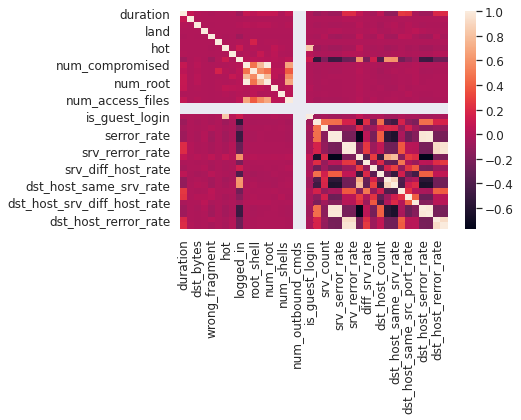

In [10]:
corr_dataframe = train_dataframe[numeric_columns].corr()
sns.heatmap(corr_dataframe)

From the heatmap, we can notice that correlation for num_outbounds_cmds with other features is constant.


In [11]:
train_dataframe['num_outbound_cmds'].unique()

array([0])

In [12]:
train_dataframe.drop('num_outbound_cmds', axis = 1, inplace = True)

In [13]:
test_dataframe.drop('num_outbound_cmds', axis = 1, inplace = True)

num_outbound_cmds coulmn has 0 values for all records, so we can drop this column

Find the features that are highly correlated and drop one feature from highly correlated feature

In [14]:
highcorr_df = (corr_dataframe.abs() > 0.9) & (corr_dataframe.abs() < 1.0) 

In [15]:
corr_var_index = (highcorr_df == True).any()
corr_var_names = corr_var_index[corr_var_index == True].index

delete_duplicate = []
corr_pairs = []

for i in corr_var_index.index:
    row = highcorr_df[i]
    delete_duplicate.append(i)
    for j in corr_var_names:
        if j not in delete_duplicate and row[j] == True:
            print(i,j,": ", corr_dataframe.loc[i,j])
            corr_pairs.append((i,j))

num_compromised num_root :  0.9989564860270104
serror_rate srv_serror_rate :  0.9932900594139392
serror_rate dst_host_serror_rate :  0.978021838092273
serror_rate dst_host_srv_serror_rate :  0.979601949917278
srv_serror_rate dst_host_serror_rate :  0.9763633089078823
srv_serror_rate dst_host_srv_serror_rate :  0.9846211977178592
rerror_rate srv_rerror_rate :  0.9891336910125826
rerror_rate dst_host_rerror_rate :  0.9289919679471647
rerror_rate dst_host_srv_rerror_rate :  0.964886035790209
srv_rerror_rate dst_host_rerror_rate :  0.9195367413800786
srv_rerror_rate dst_host_srv_rerror_rate :  0.9698414193761191
dst_host_serror_rate dst_host_srv_serror_rate :  0.9847058568468164
dst_host_rerror_rate dst_host_srv_rerror_rate :  0.9253904301448883


In [16]:
train_dataframe.drop(['num_root', 'srv_serror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
              'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','is_host_login','su_attempted','wrong_fragment','urgent'], axis = 1, inplace = True)

In [17]:
test_dataframe.drop(['num_root', 'srv_serror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
              'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','is_host_login','su_attempted','wrong_fragment','urgent'], axis = 1, inplace = True)

Perform Chi-Square test to check whether categorical features depend on the output value or not. Before that we need to encode the categorical features

In [18]:
train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   hot                          25192 non-null  int64  
 8   num_failed_logins            25192 non-null  int64  
 9   logged_in                    25192 non-null  int64  
 10  num_compromised              25192 non-null  int64  
 11  root_shell                   25192 non-null  int64  
 12  num_file_creations           25192 non-null  int64  
 13  num_shells      

In [19]:
categorical_columns = ['protocol_type', 'service', 'flag']

In [20]:
train_dataframe[categorical_columns].head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


# Label Encoding

In [21]:
label_encoder = preprocessing.LabelEncoder()
train_dataframe['protocol_type'] = label_encoder.fit_transform(train_dataframe['protocol_type'])
train_dataframe['service'] = label_encoder.fit_transform(train_dataframe['service'])
train_dataframe['flag'] = label_encoder.fit_transform(train_dataframe['flag'])
train_dataframe['class'] = label_encoder.fit_transform(train_dataframe['class'])

In [22]:
test_dataframe['protocol_type'] = label_encoder.fit_transform(test_dataframe['protocol_type'])
test_dataframe['service'] = label_encoder.fit_transform(test_dataframe['service'])
test_dataframe['flag'] = label_encoder.fit_transform(test_dataframe['flag'])

In [23]:
train_dataframe[categorical_columns].head()

,protocol_type,service,flag
0,1,19,9
1,2,41,9
2,1,46,5
3,1,22,9
4,1,22,9


To calculate chi square test we need to contigency table. At first we consider protocol_type and class. Let's take the significant value be 0.05

In [24]:
chi2_contingency(pd.crosstab(train_dataframe['protocol_type'], train_dataframe['class']))
#p value is 0.0 which is less than significant value. Hence protocol_type and class are not independent

(2035.9495530281392, 0.0, 2, array([[  771.462,   883.538],
        [ 9567.991, 10958.009],
        [ 1403.548,  1607.452]]))

In [25]:
chi2_contingency(pd.crosstab(train_dataframe['flag'], train_dataframe['class']))
#P value is 0.0 which is less than significant value. Hence flag and class are not independent

(15153.701360910532, 0.0, 10, array([[2.331e+00, 2.669e+00],
        [1.033e+03, 1.183e+03],
        [1.417e+02, 1.623e+02],
        [9.789e+00, 1.121e+01],
        [2.317e+02, 2.653e+02],
        [3.267e+03, 3.742e+03],
        [4.102e+01, 4.698e+01],
        [9.789e+00, 1.121e+01],
        [6.992e+00, 8.008e+00],
        [6.980e+03, 7.993e+03],
        [2.004e+01, 2.296e+01]]))

In [26]:
chi2_contingency(pd.crosstab(train_dataframe['service'], train_dataframe['class']))
#p value is 0.0 which is less than significant value. Hence service and class features are not independent.

(18639.26162888648, 0.0, 65, array([[1.865e+01, 2.135e+01],
        [1.026e+01, 1.174e+01],
        [8.018e+01, 9.182e+01],
        [8.810e+01, 1.009e+02],
        [6.806e+01, 7.794e+01],
        [7.645e+01, 8.755e+01],
        [5.174e+01, 5.926e+01],
        [5.920e+01, 6.780e+01],
        [4.988e+01, 5.712e+01],
        [4.894e+01, 5.606e+01],
        [5.081e+01, 5.819e+01],
        [8.484e+02, 9.716e+02],
        [3.030e+01, 3.470e+01],
        [4.237e+02, 4.853e+02],
        [2.857e+02, 3.273e+02],
        [5.128e+01, 5.872e+01],
        [4.242e+01, 4.858e+01],
        [1.706e+02, 1.954e+02],
        [1.608e+02, 1.842e+02],
        [6.507e+02, 7.453e+02],
        [5.081e+01, 5.819e+01],
        [4.475e+01, 5.125e+01],
        [3.731e+03, 4.272e+03],
        [5.267e+01, 6.033e+01],
        [4.661e-01, 5.339e-01],
        [6.433e+01, 7.367e+01],
        [6.106e+01, 6.994e+01],
        [4.288e+01, 4.912e+01],
        [3.123e+01, 3.577e+01],
        [4.195e+01, 4.805e+01],
        [3.9

# Model

In [27]:
# Naive Bayes Algorithm
from csv import reader
from random import seed
from random import randrange
from math import sqrt
from math import exp
from math import pi

# Split the dataset by class values, returns a dictionary
def split_class(dataset):
	separatedclasses = dict()
	for i in range(len(dataset)):
		temp = dataset[i]
		class_value = temp[-1]
		if (class_value not in separatedclasses):
			separatedclasses[class_value] = list()
		separatedclasses[class_value].append(temp)
	return separatedclasses

# Calculate the mean of a list of numbers
def mean(num):
	return sum(num)/float(len(num))

# Calculate the standard deviation of a list of numbers
def stdev(num):
	avg = mean(num)
	variance = sum([(x-avg)**2 for x in num]) / float(len(num)-1)
	return sqrt(variance)

# Calculate the mean, stdev and count for each column in a dataset
def compute_dataset(dataset):
	results = [(mean(column), stdev(column), len(column)) for column in zip(*dataset)]
	del(results[-1])
	return results

# Split dataset by class then calculate statistics for each row
def compute_class(dataset):
	separatedclasses = split_class(dataset)
	results = dict()
	for class_value, rows in separatedclasses.items():
		results[class_value] = compute_dataset(rows)
	return results

# Calculate the Gaussian probability distribution function for x
def compute_probability(x, mean, stdev):
  try:
    exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
    a = (1 / (sqrt(2 * pi) * stdev)) * exponent
  except ZeroDivisionError:
    a = 0.0
    exponent = 0.0
  return a

# Calculate the probabilities of predicting each class for a given row
def class_probabilities(results, row):
	total_rows = sum([results[label][0][2] for label in results])
	proba = dict()
	for class_value, class_results in results.items():
		proba[class_value] = results[class_value][0][2]/float(total_rows)
		for i in range(len(class_results)):
			mean, stdev, _ = class_results[i]
			proba[class_value] *= compute_probability(row[i], mean, stdev)
	return proba

# Predict the class for a given row
def predict(results, row):
	proba = class_probabilities(results, row)
	best_label, best_prob = None, -1
	for class_value, probability in proba.items():
		if best_label is None or probability > best_prob:
			best_prob = probability
			best_label = class_value
	return best_label

# Naive Bayes Algorithm
def naive_bayes_algo(train, test):
	summarize = compute_class(train)
	predictions = list()
	for row in test:
		output = predict(summarize, row)
		predictions.append(output)
	return(predictions)

# Test Naive Bayes on Iris Dataset
seed(1)
dataset = np.asarray(train_dataframe[0:])

pred=naive_bayes_algo(dataset[0:20154],dataset[20154:])

#print(pred)
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
print("Naive Bayes Model Results ")
print("Confusion Matrix")
print(confusion_matrix(dataset[20154::,-1],pred))
print('accuracy=%f'%(accuracy_score(dataset[20154::,-1],pred)))
print('f1-score=%f'%(f1_score(dataset[20154::,-1],pred)))


Naive Bayes Model Results 
Confusion Matrix
[[2143  220]
 [ 338 2337]]
accuracy=0.889242
f1-score=0.893349


In [28]:
Y = train_dataframe['class']
train_dataframe.drop('class', axis=1, inplace = True)

In [29]:
from sklearn import model_selection
from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB
X_train, X_valid, Y_train, Y_valid = model_selection.train_test_split(train_dataframe, Y, test_size = 0.2)

In [30]:
model = BernoulliNB()
model = model.fit(X_train, Y_train)

In [31]:
pred = model.predict(X_valid)
print("Sklearn Naive Bayes")
print("Confusion Matrix")
print(metrics.confusion_matrix(Y_valid, pred))
print('accuracy=%f'%(accuracy_score(Y_valid, pred)))
print('f1-score=%f'%(f1_score(Y_valid, pred)))

Sklearn Naive Bayes
Confusion Matrix
[[2008  325]
 [ 203 2503]]
accuracy=0.895217
f1-score=0.904590
